In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
print(f"Python Version: {sys.version}")
import tensorflow as tf
print(f"Tensorflow Version: {tf.__version__}")
import warnings
warnings.filterwarnings("ignore")

Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Tensorflow Version: 2.15.0


In [4]:
data_path = "/content/drive/MyDrive/Colab Notebooks/Brain Stroke Prediction Project/Brain_CT_Images"
data_directory = os.listdir(data_path)
data_directory

['Normal', 'Stroke']

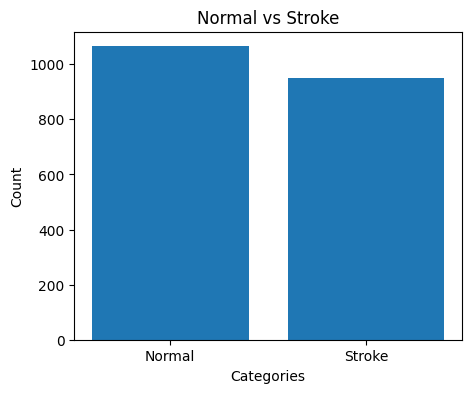

In [5]:
normal_count = len(os.listdir(os.path.join(data_path, 'Normal')))
stroke_count = len(os.listdir(os.path.join(data_path, 'Stroke')))
plt.figure(figsize=[5, 4])
plt.bar(['Normal', 'Stroke'], [normal_count, stroke_count])
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Normal vs Stroke")
plt.show()

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

def load_image_data(data_path, color, shuffle, image_size=224):
  dataset = image_dataset_from_directory(
      data_path,
      labels="inferred",
      label_mode="binary",
      class_names=["Normal", "Stroke"],
      color_mode=color,
      batch_size=None,
      shuffle=shuffle,
      image_size=(image_size, image_size),
  )
  return dataset

In [6]:
# for images, labels in dataset.take(1):
#     for i in range(9):
#         plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
#         label_text = "Stroke" if labels[i].numpy() == 1 else "Not Stroke"
#         plt.title(f"{label_text}")
#         plt.axis('off')

# plt.show()

In [12]:
def preprocess_dataset(dataset):
  train_size = int(len(dataset) * 0.8)
  train_dataset = dataset.take(train_size)
  test_dataset = dataset.skip(train_size)

  train_dataset=(
      train_dataset.map(lambda x, y: (x/255, y))
      .batch(32).shuffle(10)
      .prefetch(buffer_size=tf.data.AUTOTUNE)
  )
  test_dataset=(
      test_dataset.map(lambda x, y: (x/255, y))
      .batch(32)
      .prefetch(buffer_size=tf.data.AUTOTUNE)
  )
  return train_dataset, test_dataset

In [13]:
dataset_cnn = load_image_data(data_path, color="grayscale", shuffle=True)
train_data_cnn, test_data_cnn = preprocess_dataset(dataset_cnn)

Found 2015 files belonging to 2 classes.


### Our CNN Model

In [14]:
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout

class MyModel(tf.keras.Model):
  def __init__(self, image_size, neuron=64):
    self.image_size = image_size
    super(MyModel, self).__init__()
    self.convolution_layer_1 = Conv2D(
        filters=64,
        kernel_size = (3,3),
        padding="valid",
        strides=(2, 2),
        activation=tf.nn.relu,
        input_shape=(image_size, image_size, 1)
        )
    self.pooling_layer_1 = MaxPooling2D(
        pool_size=(2,2),
        padding="valid")
    self.convolution_layer_2 = Conv2D(
        filters=64, kernel_size=(3,3),
        padding="valid",
        strides=(2, 2),
        activation=tf.nn.relu
        )
    self.pooling_layer_2 = MaxPooling2D(
        pool_size = (2,2),
        padding="valid"
        )
    self.flatten_layer = Flatten()
    self.dense_layer_1 = Dense(units=neuron, activation=tf.nn.relu)
    self.dropout_layer_1 = Dropout(0.2)
    self.dense_layer_2 = Dense(units=neuron, activation=tf.nn.relu)
    self.dropout_layer_2 = Dropout(0.2)
    self.output_layer = Dense(units=1, activation=tf.nn.sigmoid)

  def call(self, x):
    x = self.convolution_layer_1(x)
    x = self.pooling_layer_1(x)
    x = self.convolution_layer_2(x)
    x = self.pooling_layer_2(x)
    x = self.flatten_layer(x)
    x = self.dense_layer_1(x)
    x = self.dropout_layer_1(x)
    x = self.dense_layer_2(x)
    x = self.dropout_layer_2(x)
    output = self.output_layer(x)
    return output

  def summary(self):
    x = tf.keras.Input(shape=(self.image_size, self.image_size, 1))
    model = tf.keras.Model(inputs=x, outputs= self.call(x))
    model.summary()

image_size = 224
cnn_model = MyModel(image_size)
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 111, 111, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 55, 55, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 10816)             0     

In [15]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
    )

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss= tf.keras.losses.BinaryCrossentropy(),
    metrics = ["accuracy"]
)

cnn_history = cnn_model.fit(
    train_data_cnn,
    epochs=100,
    validation_data=test_data_cnn,
    callbacks = [callback],
    verbose=0,
)

In [17]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.subplots(1, 2, figsize=(14, 5))
    plot(history.history["loss"], label="Training Loss")
    plot(history.history["val_loss"], label="Validation Loss")
    set_xlabel("Epochs")
    set_ylabel("Loss")
    set_title("Training vs Loss")
    legend()

    plt.subplots(1, 2, figsize=(14, 5))
    plot(history.history["accuracy"], label="Training Accuracy")
    plot(history.history["val_accuracy"], label="Validation Accuracy")
    set_xlabel("Epochs")
    set_ylabel("Accuracy")
    set_title("Training vs Accuracy")
    legend()

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


In [19]:
def plot_accuracy(history):
  plt.figure(figsize=(8, 3))
  #Loss
  plt.subplot(1, 2, 1)
  plt.plot(history.history["loss"], label="loss")
  plt.plot(history.history["val_loss"], label="val loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training vs Loss")
  plt.legend()
  #Accuracy
  plt.subplot(1, 2, 2)
  plt.plot(history.history["accuracy"], label="Accuracy")
  plt.plot(history.history["val_accuracy"], label="Val Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Training vs Accuracy")
  plt.legend()
  plt.show()

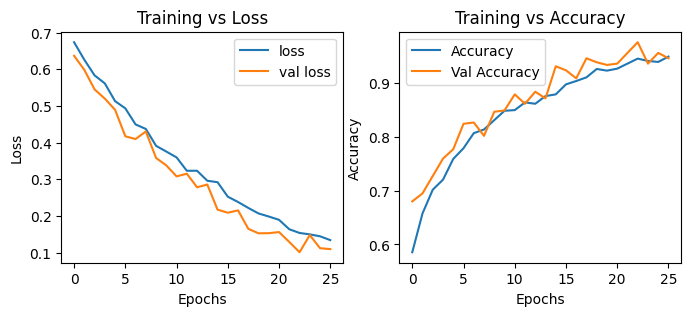

In [20]:
plot_accuracy(cnn_history)

In [21]:
 def prediction(dataset, my_model):
  x_test, y_test = next(iter(dataset))
  y_pred = my_model.predict(x_test)
  y_pred_binary = (y_pred > 0.5).astype(int)
  return y_test, y_pred_binary

In [22]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, f1_score

def classification_reports(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print(f"Accuracy Score {accuracy:.2f}")
  print(f"Recall Score {recall:.2f}")
  print(f"F1 Score {f1:.2f}")
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=[5, 4])
  sns.heatmap(cm, annot=True, cmap="summer", fmt='g',
              xticklabels=['Normal', 'Stroke'],
              yticklabels=['Normal', 'Stroke'])
  plt.title('Confusion Matrix')
  plt.show()

1/1 [==============================] - 0s 103ms/step
Accuracy Score 0.97
Recall Score 1.00
F1 Score 0.96


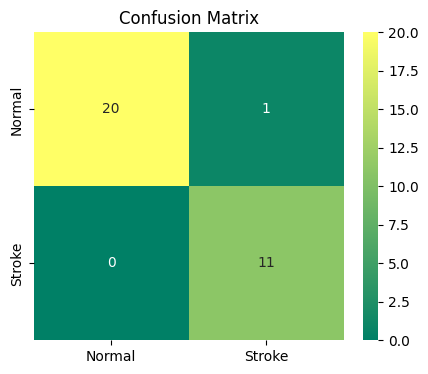

In [23]:
y_test_cnn, y_pred_cnn = prediction(test_data_cnn, cnn_model)
classification_reports(y_pred_cnn, y_test_cnn)

### VGG16



In [27]:
dataset_pretrained = load_image_data(data_path, color="rgb", shuffle=True)
train_data_pretrained, test_data_pretrained = preprocess_dataset(dataset_pretrained)

Found 2015 files belonging to 2 classes.


In [29]:
from tensorflow.keras.layers import GlobalAveragePooling2D

class VGG16_MODEL:
    def __init__(self):
        self.base_model = tf.keras.applications.VGG16(
            weights="imagenet",
            include_top=False
        )

        for layer in self.base_model.layers:
          layer.trainable = False

        x = self.base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=256, activation=tf.nn.relu)(x)
        x = Dropout(0.5)(x)
        x = Dense(units=256, activation=tf.nn.relu)(x)
        x = Dropout(0.5)(x)
        x = Dense(units=256, activation=tf.nn.relu)(x)
        x = Dropout(0.5)(x)
        output = Dense(units=1, activation=tf.nn.sigmoid)(x)

        self.pre_trained_model = tf.keras.Model(
            inputs=self.base_model.input,
            outputs=output
        )
        self.early_stopping = tf.keras.callbacks.EarlyStopping(
            patience=3,
            monitor="val_loss",
            restore_best_weights = True,
        )

    def summary(self):
        return self.base_model.summary()

    def compile(self):
      self.pre_trained_model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=["accuracy"]
      )

    def train(self, train_dataset, test_dataset, epochs):
      history = self.pre_trained_model.fit(
          train_dataset,
          validation_data=test_dataset,
          epochs=epochs,
          callbacks=[self.early_stopping],
          verbose=0
      )
      return history

    def predict(self, x):
        return self.pre_trained_model.predict(x)

vgg_model = VGG16_MODEL()
vgg_model.compile()
vgg_history = vgg_model.train(
    train_data_pretrained,
    test_data_pretrained,
    epochs=100
    )

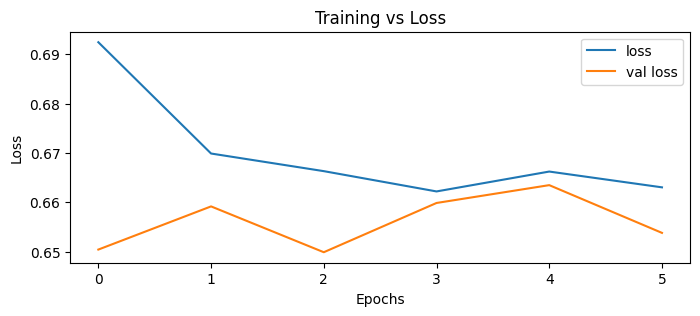

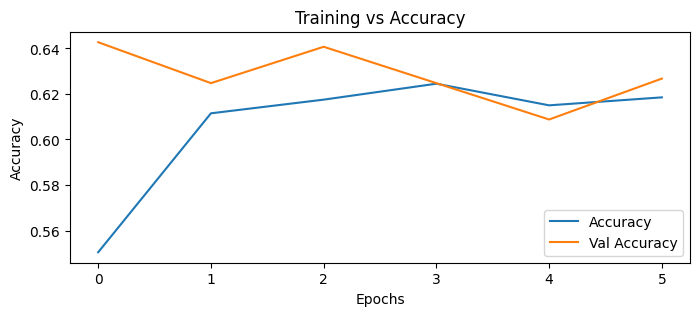

In [ ]:
plot_accuracy(vgg_history)

1/1 [==============================] - 0s 32ms/step
Accuracy Score 0.81
Recall Score 0.75
F1 Score 0.75


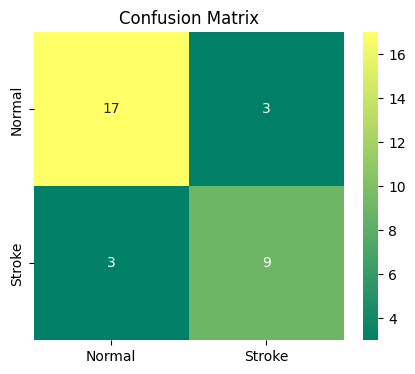

In [32]:
y_test_pretrained, y_pred_pretrained = prediction(test_data_pretrained, vgg_model)
classification_reports(y_test_pretrained, y_pred_pretrained)

### Resnet50

In [35]:
class ResNet(VGG16_MODEL):
  def __init__(self):
    super().__init__()
    self.base_model = tf.keras.applications.ResNet50(
        weights="imagenet",
        include_top=False)

resnet_model = ResNet()
resnet_model.compile()
resnet_history = resnet_model.train(
    train_data_pretrained,
    test_data_pretrained,
    epochs=100
)

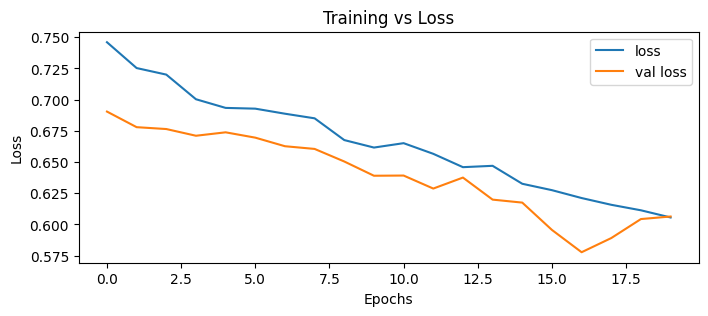

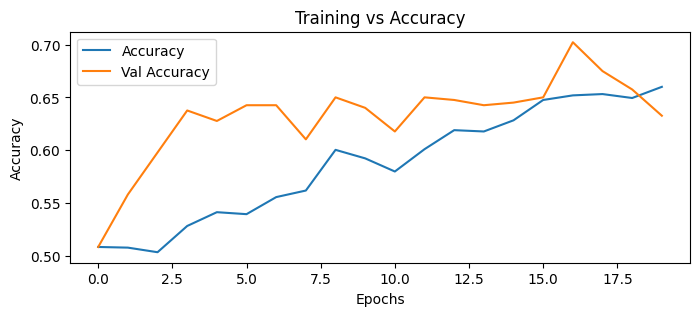

In [36]:
plot_accuracy(resnet_history)

1/1 [==============================] - 0s 159ms/step
Accuracy Score 0.66
Recall Score 0.50
F1 Score 0.59


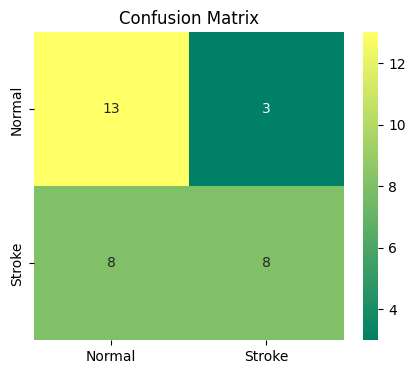

In [37]:
y_test_pretrained, y_pred_pretrained = prediction(test_data_pretrained, resnet_model)
classification_reports(y_test_pretrained, y_pred_pretrained)

### Prepareing Data For ML Algorithm

In [7]:
from sklearn.model_selection import train_test_split

dataset = load_image_data(data_path, color="grayscale", shuffle=False)
x = np.array([x.numpy() for x, _ in dataset], dtype=np.float32)
y = np.array([y.numpy() for _, y in dataset], dtype=np.int32)
x = x.reshape(x.shape[0], -1)
x = x/255

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=32)

Found 2015 files belonging to 2 classes.


### SVM

Accuracy Score 0.87
Recall Score 0.81
F1 Score 0.86


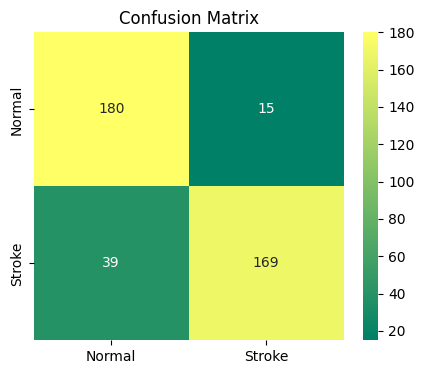

In [40]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)
classification_reports(y_test, y_pred)

### KNN

Accuracy Score 0.91
Recall Score 0.86
F1 Score 0.91


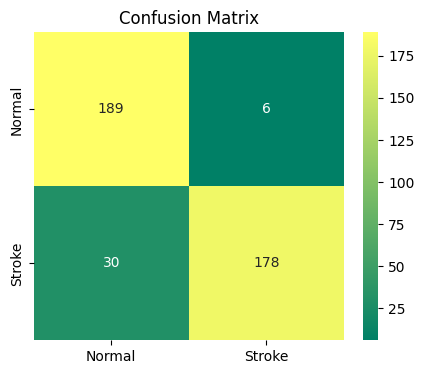

In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(x_train, y_train)
y_pred = knn_model.predict(x_test)
classification_reports(y_test, y_pred)

### Decision Tree

Accuracy Score 0.92
Recall Score 0.90
F1 Score 0.92


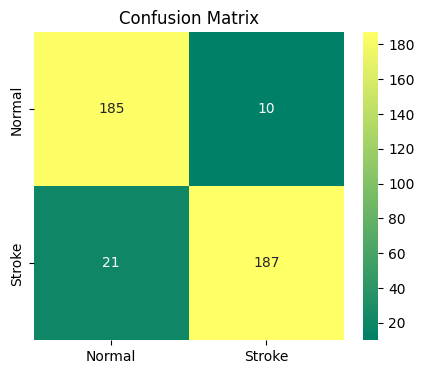

In [42]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)
y_pred = dt_model.predict(x_test)
classification_reports(y_test, y_pred)

### Random Forest

Accuracy Score 0.96
Recall Score 0.94
F1 Score 0.96


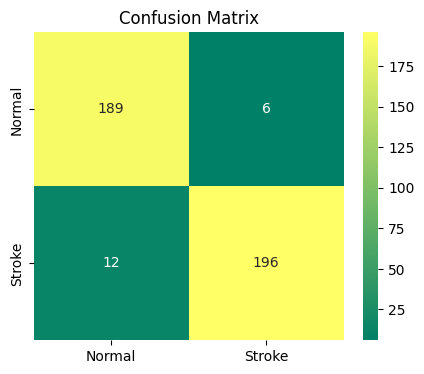

In [43]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)
classification_reports(y_test, y_pred)

### Xgboost

Accuracy Score 0.96
Recall Score 0.95
F1 Score 0.96


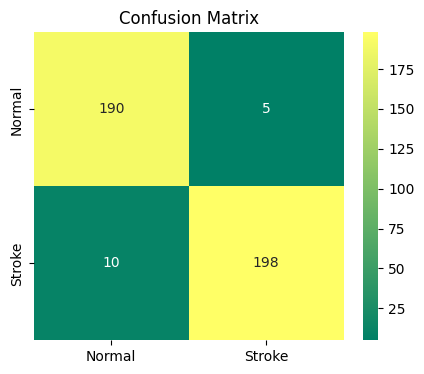

In [11]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)
classification_reports(y_test, y_pred)

### Saving Our Best Model

In [24]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Brain Stroke Prediction Project")
cnn_model.save("My_CNN_Model")

### Prediction Function

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize

def get_image_prediction(image_path, model):
    image_size = 224
    image = load_img(
        image_path, color_mode='grayscale',
        target_size=(image_size, image_size),
        interpolation='bilinear'
    )
    image = img_to_array(image) / 255.0
    image = resize(image, [image_size, image_size])
    image = tf.expand_dims(image, axis=0)

    prediction = model.predict(image)

    if prediction[0, 0] > 0.5:
        return "Stroke"
    else:
        return "Normal"

data_directory = "/content/Stroke.jpg"
result = get_image_prediction(data_directory, cnn_model)
print("Predicted Class:", result)

1/1 [==============================] - 0s 236ms/step
Predicted Class: Stroke
